notatki
probujemy na wiekszych zagadkach
wymyslic inne fitnesy
po probowac rozne parametry i to udokumentowac
punkty poprowac rozne dawanie
i nakoncu sprawdzac wyniki funbkcją podstawawą ile pol sie nie zgadza

moze bardziej porozbijac kod zeby bylo czytelniej


links
https://matplotlib.org/3.5.0/gallery/animation/dynamic_image.html

## Zadanie projektowe nr 1
##### Algorytmy genetyczne i roje cząstek
---
##### Wybrany problem to "Rozwiązywanie Fill-a-pixów"
##### Zasady:
Mamy planszę, na której musimy zamalować kratki na czarno, tak aby utworzyły obrazek.
Niektóre kratki mają wewnątrz liczbę, która informuje, ile kratek na czarno powinno być w
sąsiedztwie.
Maksimum sąsiadów to 9:
* 8 dookoła kratki
* 1 to sama kratka
* minimum to 0

Niektóre pola mogą być puste – nie informują o liczbie czarnych
kratek w sąsiedztwie, mimo że mogą je mieć.

Rzeczy które musimy zaimportować

In [9]:
import pygad
import time
import numpy as np
import matplotlib.pylab as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg

Najpierw obrazki do których będziemy dążyć.

Text(0.5, 1.0, 'image 20x20')

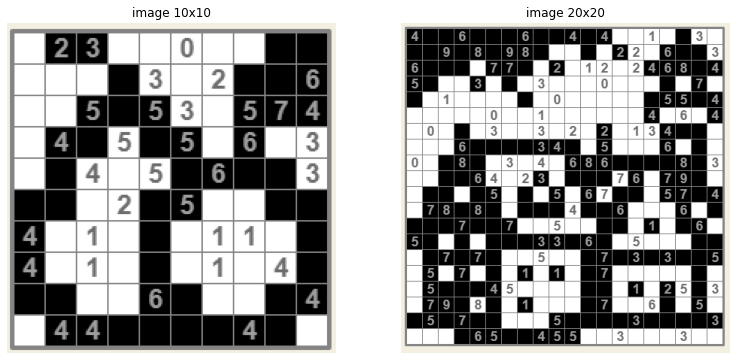

In [16]:
fill_a_pix_10_x_10_image = mpimg.imread('./fillAPix10x10.PNG')
fill_a_pix_20_x_20_image = mpimg.imread('./fillAPix20x20.PNG')

fig = plt.figure(figsize=(20, 20))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(fill_a_pix_10_x_10_image)
plt.axis('off')
plt.title("image 10x10")

fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(fill_a_pix_20_x_20_image)
plt.axis('off')
plt.title("image 20x20")

# fig.add_subplot(rows, columns, 3)
#
# # showing image
# plt.imshow(imXOR2)
# plt.axis('off')
# plt.title("XOR")

* Teraz te obrazki potrzebujemy w formie którą zrozumie nasz program.
* Zamienimy je na tablice tabilc ,a "-1" będzie oznaczało brak liczby na polu.
* Dodamy też zmienne do przechowywania kolejnych etapów poszukiwania rozwiązania by móc zrobić z tego animacje.

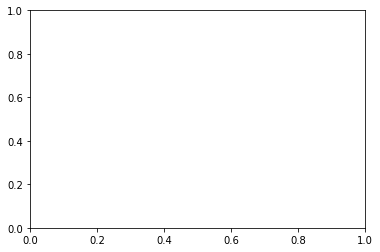

In [3]:
# obrazek 10x10 na tablice tablic
fill_a_pix_10_x_10 = [[-1, 2, 3, -1, -1, 0, -1, -1, -1, -1],
                        [-1, 2, -1, -1, 3, -1, 2, -1, -1, 6],
                        [-1, -1, 5, -1, 5, 3, -1, 5, 7, 4],
                        [-1, 4, -1, 5, -1, 5, -1, 6, -1, 3],
                        [-1, -1, 4, -1, 5, -1, 6, -1, -1, 3],
                        [-1, -1, -1, 2, -1, 5, -1, -1, -1, -1],
                        [4, -1, 1, -1, -1, -1, 1, 1, -1, -1],
                        [4, -1, 1, -1, -1, -1, 1, -1, 4, -1],
                        [-1, -1, -1, -1, 6, -1, -1, -1, -1, 4],
                        [-1, 4, 4, -1, -1, -1, -1, 4, -1, -1]]

# rozwiązanie do obrazka 10x10
fill_a_pix_10_x_10_solution = [[0, 1, 1, 0, 0, 0, 0, 0, 1, 1],
                            [0, 0, 0, 1, 0, 0, 0, 1, 1, 1],
                            [0, 0, 1, 1, 1, 0, 0, 1, 1, 1],
                            [0, 1, 1, 0, 1, 1, 0, 1, 0, 0],
                            [0, 1, 0, 0, 0, 1, 1, 1, 1, 0],
                            [1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
                            [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
                            [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
                            [1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
                            [0, 1, 1, 1, 1, 1, 1, 1, 1, 0]]

# obrazek 20x20 na tablice tablic
fill_a_pix_20_x_20 = [[4, -1, -1, 6, -1, -1, -1, 6, -1, -1, 4, -1, 4, -1, -1, 1, -1, -1, 3, -1],
                    [-1, -1, 9, -1, 8, -1, 9, 8, -1, -1, -1, -1, -1, 2, 2, -1, 6, -1, -1, 3],
                    [6, -1, -1, -1, -1, 7, 7, -1, -1, 2, -1, 1, 2, -1, 2, 4, 6, 8, -1, 4],
                    [5, -1, -1, -1, 3, -1, -1, -1, 3, -1, -1, -1, 0, -1, -1, -1, -1, -1, 7, -1],
                    [-1, -1, 1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, 5, 5, -1, 4],
                    [-1, -1, -1, -1, -1, 0, -1, -1, 1, -1, -1, -1, -1, -1, -1, 4, -1, 6, -1, 4],
                    [-1, 0, -1, -1, -1, 3, -1, -1, 3, -1, 2, -1, 2, -1, 1, 3, 4, -1, -1, -1],
                    [-1, -1, -1, 6, -1, -1, -1, -1, 3, 4, -1, -1, 5, -1, -1, -1, 6, -1, -1, -1],
                    [0, -1, -1, 8, -1, -1, 3, -1, 4, -1, 6, 8, 6, -1, -1, -1, -1, 8, -1, 3],
                    [-1, -1, -1, -1, 6, 4, -1, 2, 3, -1, -1, -1, -1, 7, 6, -1, 7, 9, -1, -1],
                    [-1, -1, -1, -1, -1, 5, -1, -1, -1, 5, -1, 6, 7, -1, -1, -1, 5, 7, -1, 4],
                    [-1, 7, 8, -1, 8, -1, -1, -1, -1, -1, 4, -1, -1, 6, -1, -1, -1, 6, -1, -1],
                    [-1, -1, -1, 7, -1, -1, 7, -1, -1, 5, -1, -1, -1, -1, -1, 1, -1, -1, 6, -1],
                    [5, -1, -1, -1, -1, -1, -1, -1, 3, 3, -1, 6, -1, -1, 5, -1, -1, -1, -1, -1],
                    [-1, -1, 7, -1, 7, -1, -1, -1, 5, -1, -1, -1, 7, -1, 3, -1, 3, -1, -1, 5],
                    [-1, 5, -1, 7, -1, -1, -1, 1, -1, 1, -1, -1, 7, -1, -1, -1, -1, -1, -1, -1],
                    [-1, 5, -1, -1, -1, 4, 5, -1, -1, -1, -1, -1, -1, -1, 1, -1, 2, 5, -1, 3],
                    [-1, 7, 9, -1, 8, -1, -1, 1, -1, -1, -1, -1, 7, -1, -1, 6, -1, -1, 5, -1],
                    [-1, 5, -1, 7, -1, -1, -1, -1, -1, 5, -1, -1, -1, -1, 3, -1, -1, -1, -1, 3],
                    [-1, -1, -1, -1, 6, 5, -1, -1, 4, 5, 5, -1, -1, 3, -1, -1, -1, 3, -1, -1]]

# rozwiązanie do obrazka 20x20
fill_a_pix_20_x_20_solution = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
                            [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
                            [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
                            [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
                            [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
                            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
                            [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
                            [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                            [0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
                            [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1],
                            [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1],
                            [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0],
                            [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1],
                            [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                            [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
                            [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0],
                            [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0],
                            [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                            [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


# zmienne potrzebne, do stworzenia animacji
fill_a_pix_10_x_10_images = []
fill_a_pix_20_x_20_images = []
fig, ax = plt.subplots()

### Najpierw fill-a-pix 10x10

### Pierwsza funkcja fitness.

##### Pomysł na funkcje:
1. Znajdujemy bloczek z liczbą inną niż "-1".
2. Liczymy ile jest czarnych bloczków
3. Patrzymy o ile się różni ta liczba od tego ile być powinno
4. otrzymany wynik zmieniamy na ujemną licze i tą są punkty karne.
5. Dążymy do tego by punktów karnych nie było czyli dążymy do zera.

Funkcja fitness_func przyjmuje jako argument "solution", czyli liste 100 zer i jedynek.
Trzeba ją zmienić na liste list 10x10, żeby móc ją porównać z naszym fillAPix10x10.
Do tego wykorzystamny funckje "change_to_array_10_x_10"


In [115]:
def change_to_array_20_x_20(array):
    # ostateczny wynik
    array_20_x_20 = []
    # pojedyncza kolumna bo do ostatecznego wyniku będziemy dodawać kolumny(listy)
    array_20_x_20_column = []
    # na ktorem indexe jestesmy w liście którą zmieniamy
    array_index = 0

    for index1 in range(20):
        for index2 in range(20):
            array_20_x_20_column.append(array[array_index])
            array_index += 1

        # dodajemy kolumne i ją resetujemy
        array_20_x_20.append(array_20_x_20_column)
        array_20_x_20_column = []

    return array_20_x_20

Teraz funkcja fitness

In [116]:
def fitness_func(solution, solution_idx):

    # liczym punkty karne, idealnie = brak punktów karnych
    penalty_points = 0

    # solution jest wypełniony zerami i jedynmaki, zero = biale pole, jedynka = czarne pole
    solution_20_x_20 = change_to_array_20_x_20(solution)

    for index1 in range(20):
        for index2 in range(20):
            if fill_a_pix_20_x_20[index1][index2] != -1:
                # sprawdz ile czarnych pol jest
                # przy sumowanie wystrczy sumować wartości pól bo czarne pole to 1, a białe to 0

                # odpowiednia liczba czarnych bloczkow to wartość pola obrazka w formie tablicy tablic
                correct_number_of_black_blocks = fill_a_pix_20_x_20[index1][index2]
                # na starcie do sumy dodjamy wartość pola ktore analizujemy
                number_of_black_blocks = solution_20_x_20[index1][index2]

                # zanim sprawdzimy wartość bloczka trzeba sprawdzyc czy ten bloczek nie wychodzi poza tablice
                # jezeli wychodzi zwracamy 0 ktore w dodawaniu nic nie zmienia

                # sprawdzamy bloczek po prawej stronie
                number_of_black_blocks += solution_20_x_20[index1][index2 + 1] if (index2 + 1) < 20 else 0
                # sprawdzamy bloczek po lewej stronie
                number_of_black_blocks += solution_20_x_20[index1][index2 - 1] if (index2 - 1) >= 0 else 0



                # sprawdzamy bloczki na górze
                number_of_black_blocks += solution_20_x_20[index1 - 1][index2] if (index1 - 1) >= 0 else 0
                number_of_black_blocks += solution_20_x_20[index1 - 1][index2 + 1] if (index1 - 1) >= 0 and (index2 + 1) < 20 else 0
                number_of_black_blocks += solution_20_x_20[index1 - 1][index2 - 1] if (index1 - 1) >= 0 and (index2 - 1) >= 0 else 0

                # sprawdzamy bloczki na dole
                number_of_black_blocks += solution_20_x_20[index1 + 1][index2] if index1 + 1 < 20 else 0
                number_of_black_blocks += solution_20_x_20[index1 + 1][index2 + 1] if (index1 + 1) < 20 and (index2 + 1) < 20 else 0
                number_of_black_blocks += solution_20_x_20[index1 + 1][index2 - 1] if (index1 + 1) < 20 and (index2 - 1) >= 0 else 0

                # o ile od prawidlowej liczby czarnych blokow roznila sie uzyskana liczba blokow razy 2
                penalty_points -= abs(correct_number_of_black_blocks - number_of_black_blocks)


    # zbieramy obrazki każdego etapu by zrobić z nich animacje
    # im = ax.imshow(solution_20_x_20, animated=True)
    # fill_a_pix_20_x_20_images.append([im])

    # karne punkty są ujemne bo im zwracana liczba jest wyższa tym lepiej
    return penalty_points

### Konfuguracja algorytmu.

In [158]:
# zakres wartość pojawiających się w solution tylko zera i jedynki
gene_space = [0, 1]

# gdy wynik jest wiekszy rowny zero konczymy
stop_crit = ["reach_0"]
# funkcja fitnes
fitness_function = fitness_func
#ile chromsomów w populacji
sol_per_pop = 40 #30
#ile genow ma chromosom
num_genes = 400 #100
#ile wylaniamy rodzicow do "rozmanazania" (okolo 50% populacji)
num_parents_mating = 8 #15
#ile pokolen
num_generations = 250 # 150
#ilu rodzicow zachowac (kilka procent)
keep_parents = 8 # 5
#jaki typ selekcji rodzicow?
#sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "sss"
#w il =u punktach robic krzyzowanie?
crossover_type = "single_point"
#mutacja ma dzialac na ilu procent genow?
#trzeba pamietac ile genow ma chromosom
mutation_type = "random"
mutation_percent_genes = 1 #2

### uruchomienie algorytmu.

In [159]:
# czyścimy z poprzednich obrazkow do animacji
fill_a_pix_20_x_20_images = []
results = 0
for a in range(10):

    ga_instance = pygad.GA(gene_space=gene_space,
                           num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           parent_selection_type=parent_selection_type,
                           keep_parents=keep_parents,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes,
                           stop_criteria=stop_crit,
                           )

    # uruchomienie algorytmu
    ga_instance.run()

    #podsumowanie: najlepsze znalezione rozwiazanie (chromosom+ocena)
    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
    # wyswietlenie wykresu: jak się zmieniała wartość karnych punktow na kolejnych etapach
    # ga_instance.plot_fitness()

    # do zrobienia obrazka potrzebujemy liste list 10x10
    solution_20_x_20 = change_to_array_20_x_20(solution)
    # zrobienie obrazka z finalnego rozwiazania
    # mask = np.array(solution_20_x_20, dtype=bool)
    # # wyświetlenie tego obrazka
    # plt.imshow(mask, cmap='gray')
    # plt.show()

    number_of_wrong_pixels = 0
    # policzenie realnej ilosc blednie uzupelnionych pexeli porownujac z rozwiazaniem
    for index1 in range (20):
        for index2 in range (20):
            if fill_a_pix_20_x_20_solution[index1][index2] != solution_20_x_20[index1][index2]:
                number_of_wrong_pixels += 1

    results += solution_fitness

    print("Real number of wrong pixels = {number_of_wrong_pixels}".format(number_of_wrong_pixels=number_of_wrong_pixels))

# stworzenie i zapisanie animacji
# ani = animation.ArtistAnimation(fig, fill_a_pix_20_x_20_images, interval=50000, blit=True,
#                                 repeat_delay=1000)
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie2.mp4", writer=writer)
print("srednia", results/10)

Fitness value of the best solution = -45.0
Real number of wrong pixels = 88
Fitness value of the best solution = -45.0
Real number of wrong pixels = 92
Fitness value of the best solution = -52.0
Real number of wrong pixels = 107
Fitness value of the best solution = -47.0
Real number of wrong pixels = 114
Fitness value of the best solution = -44.0
Real number of wrong pixels = 99
Fitness value of the best solution = -50.0
Real number of wrong pixels = 99
Fitness value of the best solution = -40.0
Real number of wrong pixels = 95
Fitness value of the best solution = -45.0
Real number of wrong pixels = 97
Fitness value of the best solution = -33.0
Real number of wrong pixels = 77
Fitness value of the best solution = -46.0
Real number of wrong pixels = 100
srednia -44.7


#### Testowanie obrazka 10x10
##### Ustawienia
ile chromsomów w populacji: sol_per_pop = 30
ile genow ma chromosom: num_genes = 100
ile wylaniamy rodzicow do "rozmanazania": num_parents_mating = 15
ile pokolen: num_generations = 150
ilu rodzicow zachowac (kilka procent): keep_parents = 5
mutacja ma dzialac na ilu procent genow?: mutation_percent_genes = 2

##### testy robione na 10 próbach
##### Obecne ustawienia:
pozwoliły osiągnąć średni wynik -6.9

##### Zmiana
"mutation_percent_genes" na wyższe liczby 6, 8
* 6 - średnia skoczyła do -15.6
* 8 - średnia skoczyła do -19.3
Wzrost mutacji pogarsza wyniki.

##### Zmiana
num_parents_mating = 10
* średnia po zmianie to -5.8
Gdy wykorzystujemy mniejszą liczbe rodziców wynik się poprawia

##### Zmiana
num_parents_mating = 10
sol_per_pop = 25
* średnia po zmianie to -7.1
Gdy zmniejszamy liczby chromosow to wynik sie pogarsza

##### Zmiana
num_parents_mating = 10
mutation_percent_genes = 1
* średnia po zmianie to -4.4
* najlepszy wynik to -2.0
Zmniejszenie losowości znacznie poprawiło wyniki

#### Testowanie obrazka 20x20
##### Ustawienia
ile chromsomów w populacji: sol_per_pop = 30
ile genow ma chromosom: num_genes = 200
ile wylaniamy rodzicow do "rozmanazania": num_parents_mating = 15
ile pokolen: num_generations = 150
ilu rodzicow zachowac (kilka procent): keep_parents = 5
mutacja ma dzialac na ilu procent genow?: mutation_percent_genes = 2

Rój

In [6]:
def endurance(params):
    # liczym punkty karne, idealnie = brak punktów karnych
    penalty_points = 0
    print(params)

    # solution jest wypełniony zerami i jedynmaki, zero = biale pole, jedynka = czarne pole
    solution_20_x_20 = change_to_array_20_x_20(params)

    for index1 in range(20):
        for index2 in range(20):
            if fill_a_pix_20_x_20[index1][index2] != -1:
                # sprawdz ile czarnych pol jest
                # przy sumowanie wystrczy sumować wartości pól bo czarne pole to 1, a białe to 0

                # odpowiednia liczba czarnych bloczkow to wartość pola obrazka w formie tablicy tablic
                correct_number_of_black_blocks = fill_a_pix_20_x_20[index1][index2]
                # na starcie do sumy dodjamy wartość pola ktore analizujemy
                number_of_black_blocks = solution_20_x_20[index1][index2]

                # zanim sprawdzimy wartość bloczka trzeba sprawdzyc czy ten bloczek nie wychodzi poza tablice
                # jezeli wychodzi zwracamy 0 ktore w dodawaniu nic nie zmienia

                # sprawdzamy bloczek po prawej stronie
                number_of_black_blocks += solution_20_x_20[index1][index2 + 1] if (index2 + 1) < 20 else 0
                # sprawdzamy bloczek po lewej stronie
                number_of_black_blocks += solution_20_x_20[index1][index2 - 1] if (index2 - 1) >= 0 else 0



                # sprawdzamy bloczki na górze
                number_of_black_blocks += solution_20_x_20[index1 - 1][index2] if (index1 - 1) >= 0 else 0
                number_of_black_blocks += solution_20_x_20[index1 - 1][index2 + 1] if (index1 - 1) >= 0 and (index2 + 1) < 20 else 0
                number_of_black_blocks += solution_20_x_20[index1 - 1][index2 - 1] if (index1 - 1) >= 0 and (index2 - 1) >= 0 else 0

                # sprawdzamy bloczki na dole
                number_of_black_blocks += solution_20_x_20[index1 + 1][index2] if index1 + 1 < 20 else 0
                number_of_black_blocks += solution_20_x_20[index1 + 1][index2 + 1] if (index1 + 1) < 20 and (index2 + 1) < 20 else 0
                number_of_black_blocks += solution_20_x_20[index1 + 1][index2 - 1] if (index1 + 1) < 20 and (index2 - 1) >= 0 else 0

                # o ile od prawidlowej liczby czarnych blokow roznila sie uzyskana liczba blokow razy 2
                penalty_points -= abs(correct_number_of_black_blocks - number_of_black_blocks)

    return penalty_points

def f(x):
    n_particles = x.shape[0]
    j = [endurance(x[i]) for i in range(n_particles)]
    return np.array(j)

In [8]:
import pyswarms as ps
import matplotlib.pyplot as plt
from pyswarms.utils.plotters import plot_cost_history
import numpy as np
import math


options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# wprowadzamy ograniczenia
x_max = np.ones(400)
x_min = np.zeros(400)
my_bounds = (x_min, x_max)

optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=400,
                                    options=options, bounds=my_bounds)
optimizer.optimize(f, iters=1000)

cost_history = optimizer.cost_history
plot_cost_history(cost_history)
plt.show()

2022-04-14 00:23:33,313 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1000

[0.71295087 0.0879331  0.92700873 0.55764542 0.40239198 0.79154598
 0.97292084 0.65195287 0.48609014 0.96618741 0.35727982 0.48457032
 0.56588604 0.76263876 0.15384417 0.33051275 0.66085204 0.28571531
 0.57014604 0.79740542 0.8313623  0.09798947 0.63323898 0.02000294
 0.53380027 0.58925844 0.78450391 0.00920952 0.65717524 0.59192294
 0.75801905 0.73728395 0.20366682 0.18847221 0.03999227 0.18094085
 0.70163888 0.07683831 0.81430678 0.60609479 0.98787098 0.95049981
 0.86518325 0.61551062 0.3038143  0.88942679 0.83702551 0.24442408
 0.70264618 0.91768449 0.03086088 0.32343529 0.04097753 0.04014816
 0.00560929 0.98605724 0.32902136 0.1721499  0.80578743 0.03141781
 0.86029875 0.1950537  0.01260561 0.71943589 0.76544995 0.83085828
 0.65851517 0.29862495 0.43453337 0.12473607 0.45772195 0.24089275
 0.23166023 0.30789205 0.49772745 0.40872484 0.26141828 0.51869295
 0.52712047 0.26374713 0.21177584 0.25866316 0.60582536 0.43406159
 0.61794308 0.85511635 0.83648123 0.03638141 0.40323661 0.2460

NameError: name 'change_to_array_20_x_20' is not defined